In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [8]:
file_path = r"C:\Users\19114\netflixtvshowclust\NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv"
df = pd.read_csv(file_path)
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values Count:")
print(df.isnull().sum())
print(f"\nDataset shape: {df.shape}")

  show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-13     80 min   
4   

In [13]:
#Filling missing 'director' and 'cast' with "Unknown"
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)

#Filling missing 'country' with the mode (most frequent country)
country_mode = df['country'].mode()[0]
df['country'].fillna(country_mode, inplace=True)
print(f"Filled missing 'country' values with: {country_mode}")

#Dropping the few rows with missing 'rating' and 'date_added'
df.dropna(subset=['rating', 'date_added'], inplace=True)


# Check if all missing values have been handled
print("\nMissing Values Count After Cleaning:")
print(df.isnull().sum())
print(f"\nNew dataset shape: {df.shape}")

Filled missing 'country' values with: United States

Missing Values Count After Cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

New dataset shape: (7770, 12)


In [11]:
# Checking if 'date_added' is a string before converting
if pd.api.types.is_string_dtype(df['date_added']):
    df['date_added'] = pd.to_datetime(df['date_added'].str.strip())
    print("'date_added' column converted to datetime.")

# Checking if 'duration' column exists before trying to process it
if 'duration' in df.columns:
    # Handle the 'duration' column
    df['duration_min'] = 0
    df['duration_seasons'] = 0
#creating new column
    df.loc[df['type'] == 'Movie', 'duration_min'] = df.loc[df['type'] == 'Movie', 'duration'].str.replace(' min', '').astype(int)
    df.loc[df['type'] == 'TV Show', 'duration_seasons'] = df.loc[df['type'] == 'TV Show', 'duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)
    
    # Drop the original 'duration' column
    df.drop(columns=['duration'], inplace=True)
    print("'duration' column processed and replaced.")

# Checking if 'release_year' column exists before trying to process it
if 'release_year' in df.columns:
    # Create the 'content_age' feature
    current_year = 2025
    df['content_age'] = current_year - df['release_year']
    
    # Drop the original 'release_year' column
    df.drop(columns=['release_year'], inplace=True)
    print("'content_age' feature created and 'release_year' dropped.")


print("\nFirst 5 rows with new features:")
print(df.head())

print("\nDataset Info After Feature Engineering:")
df.info()

'duration' column processed and replaced.
'content_age' feature created and 'release_year' dropped.

First 5 rows with new features:
  show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added rating  \
0    August 14, 2020  TV-MA   
1  December 23, 2016  TV-MA   
2  December 20, 2018      R   
3  November 16, 2017  PG-13

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Encode 'listed_in' (Genres) using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['listed_in'])

# Converting the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=df.index)


# 2. Encoding 'rating' using One-Hot Encoding
rating_dummies = pd.get_dummies(df['rating'], prefix='rating')


# 3. Scale Numerical Features
numerical_features = df[['duration_min', 'duration_seasons', 'content_age']]
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(numerical_features)

# Converting the scaled numerical features back to a DataFrame
scaled_df = pd.DataFrame(scaled_numerical, columns=numerical_features.columns, index=df.index)


# We reset the index to ensure a clean concatenation
final_features = pd.concat([tfidf_df.reset_index(drop=True), 
                            rating_dummies.reset_index(drop=True), 
                            scaled_df.reset_index(drop=True)], axis=1)

print("Shape of our final features matrix:", final_features.shape)
print("\nFirst 5 rows of the final features matrix:")
print(final_features.head())

Shape of our final features matrix: (7787, 61)

First 5 rows of the final features matrix:
     action  adventure  anime  british  children  classic  comedies  comedy  \
0  0.000000   0.000000    0.0      0.0       0.0      0.0       0.0     0.0   
1  0.000000   0.000000    0.0      0.0       0.0      0.0       0.0     0.0   
2  0.000000   0.000000    0.0      0.0       0.0      0.0       0.0     0.0   
3  0.336502   0.336502    0.0      0.0       0.0      0.0       0.0     0.0   
4  0.000000   0.000000    0.0      0.0       0.0      0.0       0.0     0.0   

   crime  cult  ...  rating_TV-G  rating_TV-MA  rating_TV-PG  rating_TV-Y  \
0    0.0   0.0  ...        False          True         False        False   
1    0.0   0.0  ...        False          True         False        False   
2    0.0   0.0  ...        False         False         False        False   
3    0.0   0.0  ...        False         False         False        False   
4    0.0   0.0  ...        False         False   

Elbow method plot has been generated and saved as 'elbow_method.png'


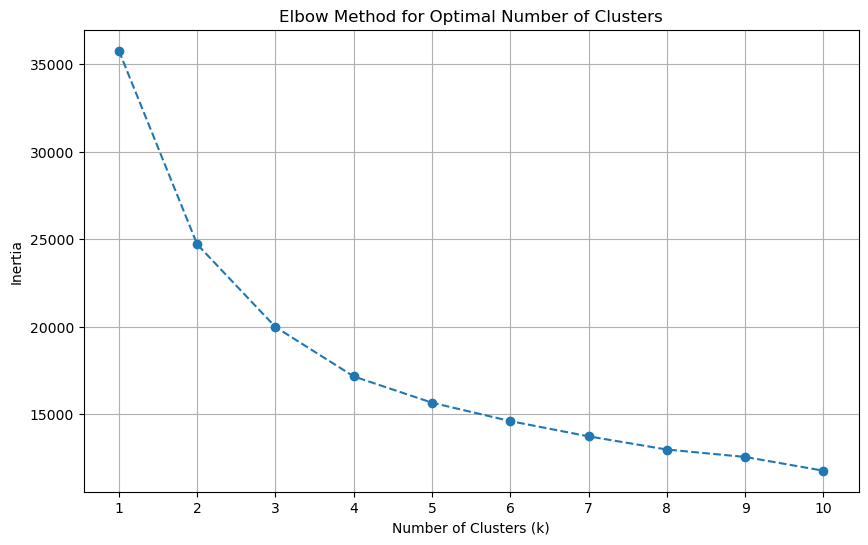

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Elbow Method for Optimal k ---

# We will store the inertia values for each k here
inertia = []
k_range = range(1, 11) 

# Loop through each k and run KMeans
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(final_features)
    inertia.append(kmeans.inertia_)
#plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.savefig('elbow_method.png') # This saves the plot as an image

print("Elbow method plot has been generated and saved as 'elbow_method.png'")

In [29]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Fitting the model and assign cluster labels
df['cluster'] = kmeans.fit_predict(final_features)

# --- Initial Cluster Analysis ---
# Check the size of each cluster
print("Number of items in each cluster:")
print(df['cluster'].value_counts())

# Analyze the characteristics of each cluster
print("\nCluster characteristics (mean values for numerical features):")
cluster_analysis = df.groupby('cluster')[['content_age', 'duration_min', 'duration_seasons']].mean()
print(cluster_analysis)

# Display a few examples from each cluster
print("\n--- Examples from each cluster ---")
for i in range(optimal_k):
    print(f"\n--- Cluster {i} Examples ---")
    print(df[df['cluster'] == i][['title', 'type', 'listed_in']].head())

Number of items in each cluster:
cluster
0    4903
1    2389
2     478
Name: count, dtype: int64

Cluster characteristics (mean values for numerical features):
         content_age  duration_min  duration_seasons
cluster                                             
0           9.663471     98.002651          0.000000
1           8.458769      0.045207          1.753035
2          38.460251    110.853556          0.075314

--- Examples from each cluster ---

--- Cluster 0 Examples ---
   title   type                                          listed_in
1   7:19  Movie                       Dramas, International Movies
2  23:59  Movie                Horror Movies, International Movies
3      9  Movie  Action & Adventure, Independent Movies, Sci-Fi...
4     21  Movie                                             Dramas
6    122  Movie                Horror Movies, International Movies

--- Cluster 1 Examples ---
     title     type                                          listed_in
0       3%

In [31]:
from sklearn.metrics import silhouette_score

score = silhouette_score(final_features, df['cluster'])
print(f"The Silhouette Score for our K-Means model (k=3) is: {score:.4f}")

The Silhouette Score for our K-Means model (k=3) is: 0.3530


PCA plot has been generated and saved as 'pca_cluster_plot.png'


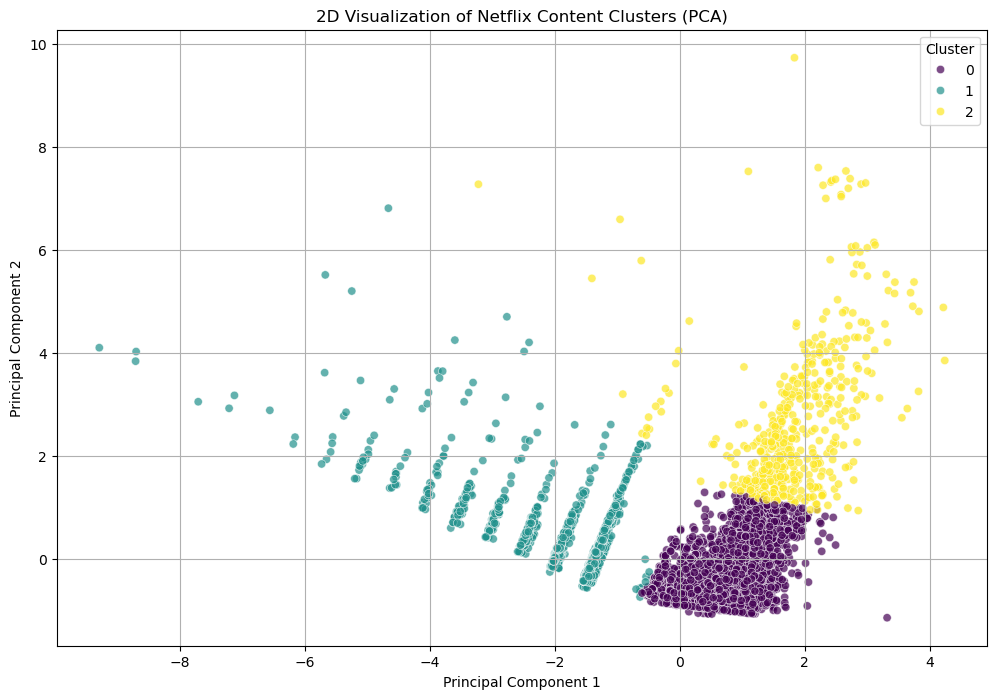

In [33]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# --- Reduce dimensions using PCA ---
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(final_features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
# We need to reset the index of the original df's cluster series to align it
pca_df['cluster'] = df['cluster'].reset_index(drop=True)


#plotting the cluser 
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', alpha=0.7)

plt.title('2D Visualization of Netflix Content Clusters (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('pca_cluster_plot.png')

print("PCA plot has been generated and saved as 'pca_cluster_plot.png'")

In [35]:
from sklearn.metrics import davies_bouldin_score

# Calculate the Davies-Bouldin Score
db_score = davies_bouldin_score(final_features, df['cluster'])

print(f"The Davies-Bouldin Score for our K-Means model (k=3) is: {db_score:.4f}")

The Davies-Bouldin Score for our K-Means model (k=3) is: 1.1235


t-SNE plot has been generated and saved as 'tsne_cluster_plot.png'


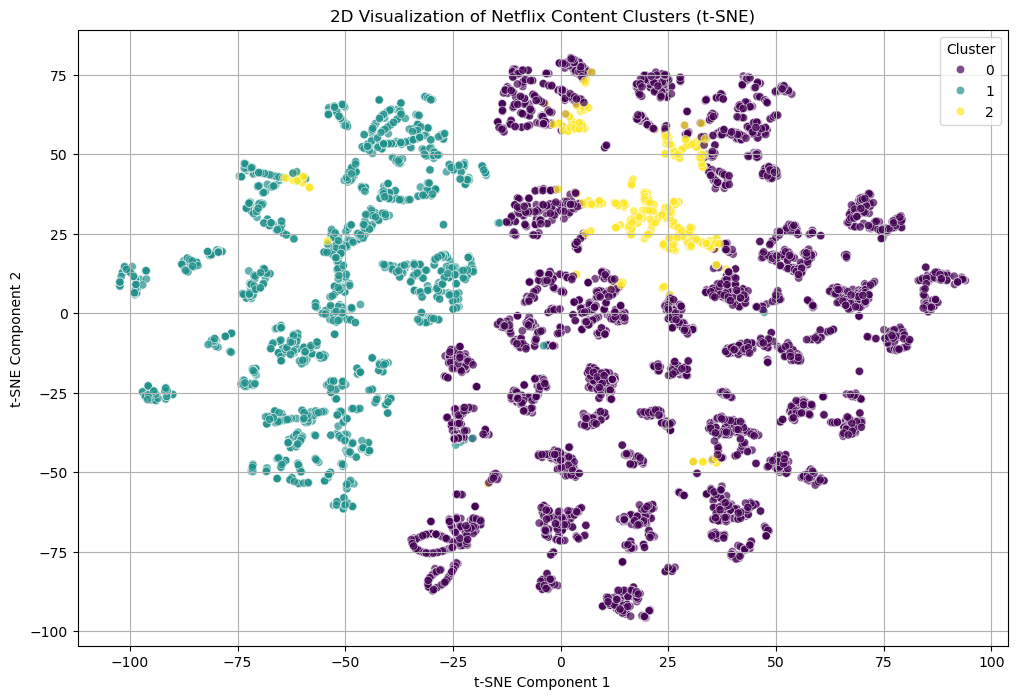

In [43]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

#Reducing dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(final_features)

#DataFrame with the t-SNE results
tsne_df = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = df['cluster'].reset_index(drop=True)

#Plotting the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=tsne_df, palette='viridis', alpha=0.7)

plt.title('2D Visualization of Netflix Content Clusters (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.savefig('tsne_cluster_plot.png')

print("t-SNE plot has been generated and saved as 'tsne_cluster_plot.png'")
plt.show()

In [45]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

#Running Hierarchical Clustering ---
#using the 'ward' linkage method which tends to find similarly sized clusters.
#n_clusters=3 to compare it directly with our K-Means model.
print("Running Hierarchical Clustering...")
hierarchical = AgglomerativeClustering(n_clusters=3, linkage='ward')
hc_labels = hierarchical.fit_predict(final_features)
print("Hierarchical Clustering finished.")


hc_score = silhouette_score(final_features, hc_labels)

print(f"\nThe Silhouette Score for Hierarchical Clustering is: {hc_score:.4f}")
print(f"For comparison, the K-Means Silhouette Score was: 0.3530")

Running Hierarchical Clustering...
Hierarchical Clustering finished.

The Silhouette Score for Hierarchical Clustering is: 0.3530
For comparison, the K-Means Silhouette Score was: 0.3530


In [47]:
# Saving the final processed DataFrame to a CSV file
df.to_csv('processed_netflix_data_with_clusters.csv', index=False)

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np

print("Running DBSCAN...")
dbscan = DBSCAN(eps=2.5, min_samples=5)
db_labels = dbscan.fit_predict(final_features)
print("DBSCAN finished.")

n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)

print(f"\nEstimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points (outliers): {n_noise_}")

if n_clusters_ > 1:
    db_score = silhouette_score(final_features, db_labels)
    print(f"\nThe Silhouette Score for DBSCAN is: {db_score:.4f}")
else:
    print("\nDBSCAN did not find more than one cluster. Cannot calculate Silhouette Score.")

print(f"For comparison, the K-Means Silhouette Score was: 0.3530")

Running DBSCAN...
DBSCAN finished.

Estimated number of clusters: 1
Estimated number of noise points (outliers): 4

DBSCAN did not find more than one cluster. Cannot calculate Silhouette Score.
For comparison, the K-Means Silhouette Score was: 0.3530
